In [3]:
''' 
    Copyright (C) 2022 by Marinara Marcato
         <marinara.marcato@tyndall.ie>, Tyndall National Institute
        University College Cork, Cork, Ireland.
'''

# ------------------------------------------------------------------------- #
#                                  Imports                                  #    
# ------------------------------------------------------------------------- # 
import os, joblib, sys
from time import time
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GroupKFold, GridSearchCV

import multiprocessing as mp
print("Number of Logical processors: ", mp.cpu_count())


# ------------------------------------------------------------------------- #
#                             Local Imports                                 #    
# ------------------------------------------------------------------------- # 

# Define local directories
dir_current = os.getcwd()
dir_base = os.path.dirname(dir_current)
dir_modules = os.path.join(dir_base, 'src', '__modules__')
# Set path variable
sys.path.append(dir_modules)

# Local Modules
import imports, analyse, learn, evaluate 

Number of Logical processors:  40


In [4]:
# ------------------------------------------------------------------------- #
#                           Model Parameters                                #    
# ------------------------------------------------------------------------- # 

# select dataset  
ft = 'final'
# select model parameters
exp = 3
mdl = 'anomaly'
slt = 'SKB'
clf = 'RF'
param = 1 
run = '{}-{}-{}-{}-{}.pkl'.format(exp, mdl, slt, clf, param)


# directory where the dataset is located
dir_df = os.path.join(dir_base, 'data', ft)
# directory to save the model
dir_model = os.path.join(dir_base, 'models', ft)

# ------------------------------------------------------------------------- #
#                                   Classes                                 #    
# ------------------------------------------------------------------------- # 

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, dtype=None):
        self.attribute_names = attribute_names
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_selected = X[self.attribute_names]
        if self.dtype:
            return X_selected.astype(self.dtype).values
        return X_selected.values

class gs_results:
    # Storing Grid Search results
    def __init__(self, gs):
        self.cv_results_ = gs.cv_results_
        self.best_estimator_ = gs.best_estimator_
        self.best_params_ = gs.best_params_
        self.best_score_ = gs.best_score_



In [5]:
# ------------------------------------------------------------------------- #
#                              Importing Dataset                            #
# ------------------------------------------------------------------------- #
# importing previously created dataset
df = pd.read_csv(os.path.join(dir_df, 'df-all-dev.csv'), 
                index_col = ['Timestamp'], 
                parse_dates = ['Timestamp'],
                dayfirst = True,
                date_parser = lambda x: pd.to_datetime(x, format = '%Y-%m-%d %H:%M:%S.%f')    )

# define all features 
feat = df.columns[:-6]

# prepare dataframe for evaluation: select features, label,
#   cv strategy (group = dogs, stractified folds labels proportion)
X = df.loc[:, feat]
y = df.loc[:, 'Shake'].values
groups = df.loc[:,'Dog']

In [6]:
# ------------------------------------------------------------------------- #
#                Machine Learning - Isolation Forest                        #
# ------------------------------------------------------------------------- # 

from imblearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest

pipe = Pipeline([ 
    ('ft', DataFrameSelector(feat,'float64')),
    ('slt', SelectKBest(score_func = f_classif)),
    ('clf', IsolationForest(n_jobs = 1, random_state = 0,
                max_features = 1.0 # selects all features
                ))]
    )

params = { 
            'slt__k':  [10],#, 20, 30, 50, 80, 120], 
            #'clf__n_estimators': [25, 50, 100, 250, 500],
            'clf__contamination': [0.005],# 0.01]#, 0.05, 0.1]
        }


cv = GroupKFold(n_splits = 10).split(X, y, groups = groups)

In [7]:

# ------------------------------------------------------------------------- #
#                    Machine Learning - One-Class SVM                       #
# ------------------------------------------------------------------------- # 
start_time = time()
gs = GridSearchCV(pipe, param_grid = params, 
        scoring = 'f1_weighted', \
        n_jobs = 40, cv = cv, return_train_score = True)
gs.fit(X,y, groups = groups)
end_time = time()
duration = end_time - start_time
print("--- %s seconds ---" % (duration))


# save gs results to pickle file
gs_path = os.path.join(dir_current, run)
print(gs_path)
joblib.dump(gs_results(gs), gs_path, compress = 1 )

/ichec/work/tieng028c/venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1618] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/ichec/work/tieng028c/venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


--- 10.87852692604065 seconds ---
/ichec/home/users/mmarcato/dog_posture/jupyter/3-anomaly-SKB-RF-1.pkl


['/ichec/home/users/mmarcato/dog_posture/jupyter/3-anomaly-SKB-RF-1.pkl']

In [8]:

# load grid search results from pickle file
gs_path = os.path.join(dir_base, 'jupyter')
gs_rf =  joblib.load(os.path.join(gs_path, run))
print('Evaluate Grid Search output\n')
evaluate.gs_output(gs_rf)

# add cv results to a dataframe 
df_cv = pd.DataFrame(gs_rf.cv_results_)
df_cv['train_test_gap'] = df_cv['mean_train_score'] - df_cv['mean_test_score']
opt = df_cv.filter(like = "param_").columns.to_list()
for col in opt: print(col, len(df_cv[col].unique()), df_cv[col].unique())
print('Hyperparameters combinations: ', df_cv.shape[0])

Evaluate Grid Search output

Best Estimator 
Test mean: 0.9949	 std: 0.0030
Train mean: 0.9949 	 std:  0.0003
parameters: {'clf__contamination': 0.005, 'slt__k': 10}
param_clf__contamination 1 [0.005]
param_slt__k 1 [10]
Hyperparameters combinations:  1


In [10]:

# ------------------------------------------------------------------------- #
#                             Import Test data                              #
# ------------------------------------------------------------------------- #
print('\n\nImport Test Set\n')
# directory where the datasets are located
df_dir = os.path.join(dir_base, 'data', 'final')

# select test dataframe and label according to model
# EXPERIMENT 3 - ANOMALY
label = 'Shake'
# df_test = imports.posture(df_dir, 'df-all-test')
df_test = pd.read_csv(os.path.join(dir_df, 'df-all-test.csv'), 
                index_col = ['Timestamp'], 
                parse_dates = ['Timestamp'],
                dayfirst = True,
                date_parser = lambda x: pd.to_datetime(x, format = '%Y-%m-%d %H:%M:%S.%f')    )

# print dataframe stats
print('Model:', mdl)
print('Dataset:', df_test.shape)
print('Label:', df_test.groupby(label)[label].count())

# select test data for prediction
X_true = df_test.iloc[:,:-6]
y_true = df_test.loc[:, label]
labels = y_true.unique()




Import Test Set

Model: anomaly
Dataset: (4866, 3336)
Label: Shake
-1      18
 1    4848
Name: Shake, dtype: int64


   label  f1_score
0      1  0.998143
1     -1  0.550000

f1 scores
macro: 0.7741
micro: 0.9963
weighted: 0.9965


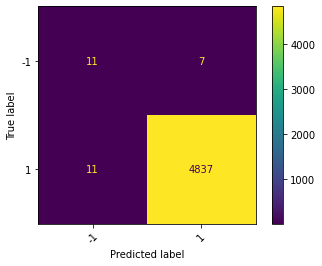

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
# ------------------------------------------------------------------------- #
#              Calculate f1-scores for model in Test Set                    #
# ------------------------------------------------------------------------- #
# Use best estimator to predict on test set
y_rf = gs_rf.best_estimator_.predict(X_true)

## Calculate f1-scores
df_f1_class = pd.DataFrame({
    'label':  labels,
    'f1_score': f1_score(y_true, y_rf, labels = labels, average = None)
})

print(df_f1_class)
print('\nf1 scores')
print('macro: {:0.4f}'.format(f1_score(y_true, y_rf, average = 'macro')))
print('micro: {:0.4f}'.format(f1_score(y_true, y_rf, average = 'micro')))
print('weighted: {:0.4f}'.format(f1_score(y_true, y_rf, average = 'weighted')))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_rf, xticks_rotation = 45)
